# llama3-llava-next-8b

## Test

In [1]:
import torch
print(torch.cuda.is_available())
print(torch.version.cuda)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,3,4"
print(os.environ["CUDA_VISIBLE_DEVICES"])

True
12.4
1,2,3,4


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

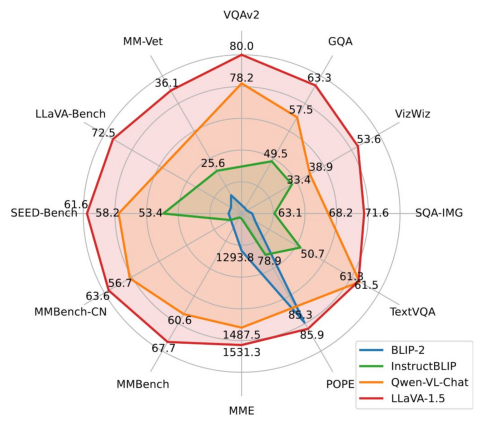

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


user


What is shown in this image?assistant


The image shows a radar chart, also known as a spider chart or a web chart, which is a type of graph used to display multivariate data in the form of a two-dimensional chart of three or more quantitative variables represented on axes starting from the same point. Each axis represents a different variable, and the values are plotted along each axis and connected to form a polygon.

In this particular radar chart, there are several axes labeled with different variables, such as "MM-Vet," "LLaVA-Bench," "SEED-Bench," "MMBench-CN," "MMBench," "TextVQA,"


In [2]:
from transformers import LlavaNextProcessor, LlavaNextForConditionalGeneration
import torch
from PIL import Image
import requests
import matplotlib.pyplot as plt
import json
import gc

model_id = "llava-hf/llama3-llava-next-8b-hf"

processor = LlavaNextProcessor.from_pretrained(model_id)
model = LlavaNextForConditionalGeneration.from_pretrained(
    model_id, 
    torch_dtype=torch.float16, 
    device_map="auto",
    attn_implementation="sdpa"
    )

model_name = model_id.split("/")[1]

with open(f"../../model_config/{model_name}.json", "r") as f:
    config = json.load(f)

patch_size = config["vision_config"]["patch_size"]
vision_feature_select_strategy = config["vision_feature_select_strategy"]

processor.patch_size = patch_size
processor.vision_feature_select_strategy = vision_feature_select_strategy

# prepare image and text prompt, using the appropriate prompt template
url = "https://github.com/haotian-liu/LLaVA/blob/1a91fc274d7c35a9b50b3cb29c4247ae5837ce39/images/llava_v1_5_radar.jpg?raw=true"
image = Image.open(requests.get(url, stream=True).raw)

plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis('off')
plt.show()

# Define a chat histiry and use `apply_chat_template` to get correctly formatted prompt
# Each value in "content" has to be a list of dicts with types ("text", "image") 
conversation = [
    {

      "role": "user",
      "content": [
          {"type": "text", "text": "What is shown in this image?"},
          {"type": "image"},
        ],
    },
]
prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)

inputs = processor(images=image, text=prompt, return_tensors="pt").to(model.device)

# autoregressively complete prompt
output = model.generate(**inputs, max_new_tokens=128)

print(processor.decode(output[0], skip_special_tokens=True))

